# 프로젝트 : Segmentation map으로 도로 이미지 만들기

## 평가지표

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.  
데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.	
U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.	
10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

### pix2pix 

- Pix2Pix는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델.

- 한 이미지의 픽셀에서 다른 이미지의 픽셀로(pixel to pixel) 변환한다는 뜻. 

- 최근 활발하게 연구 및 응용되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 됨.

- 노이즈와 레이블 정보를 함께 입력했던 cGAN은 fully-connected 레이어를 연속적으로 쌓아 만들었지만, `이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용`됨.

![image](https://velog.velcdn.com/images%2Fwilko97%2Fpost%2Fa785b691-b431-4f0e-ae1a-c86af3996323%2Fimage.png)


pix2pix = cgan + paired image generator - noise vector

noise vector 대신 image를 입력으로 받음 <- Unet 활용 (generator)



[cgan 관련자료 1](https://aistudy9314.tistory.com/75)  

[cgan 관련자료 2](https://velog.io/@wilko97/%EB%85%BC%EB%AC%B8%EC%8B%A4%EC%8A%B5-Pix2Pix)

In [1]:
# !wget https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip

--2023-07-18 11:20:23--  https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 18.172.167.190, 18.172.167.92, 18.172.167.54, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|18.172.167.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30179339 (29M) [application/zip]
Saving to: ‘cityscapes.zip’

cityscapes.zip      100%[===================>]  28.78M  --.-KB/s    in 0.1s    

2023-07-18 11:20:23 (204 MB/s) - ‘cityscapes.zip’ saved [30179339/30179339]



In [3]:
# !unzip -l cityscapes.zip | head # 폴더 만들어야하나 확인

Archive:  cityscapes.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2020-10-28 09:30   cityscapes/
        0  2020-10-28 09:31   cityscapes/train/
    32121  2019-10-01 18:19   cityscapes/train/1.jpg
    34325  2019-10-01 18:19   cityscapes/train/100.jpg
    26671  2019-10-01 18:19   cityscapes/train/1000.jpg
    28171  2019-10-01 18:19   cityscapes/train/101.jpg
    30072  2019-10-01 18:19   cityscapes/train/102.jpg


In [4]:
# !unzip cityscapes.zip

Archive:  cityscapes.zip
   creating: cityscapes/
   creating: cityscapes/train/
  inflating: cityscapes/train/1.jpg  
  inflating: cityscapes/train/100.jpg  
  inflating: cityscapes/train/1000.jpg  
  inflating: cityscapes/train/101.jpg  
  inflating: cityscapes/train/102.jpg  
  inflating: cityscapes/train/106.jpg  
  inflating: cityscapes/train/109.jpg  
  inflating: cityscapes/train/112.jpg  
  inflating: cityscapes/train/113.jpg  
  inflating: cityscapes/train/114.jpg  
  inflating: cityscapes/train/116.jpg  
  inflating: cityscapes/train/119.jpg  
  inflating: cityscapes/train/12.jpg  
  inflating: cityscapes/train/124.jpg  
  inflating: cityscapes/train/128.jpg  
  inflating: cityscapes/train/135.jpg  
  inflating: cityscapes/train/137.jpg  
  inflating: cityscapes/train/139.jpg  
  inflating: cityscapes/train/140.jpg  
  inflating: cityscapes/train/144.jpg  
  inflating: cityscapes/train/148.jpg  
  inflating: cityscapes/train/153.jpg  
  inflating: cityscapes/train/154.jpg  
 

In [5]:
os.listdir('cityscapes')

['train', 'val']

In [1]:
# 필요 module 호출
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import data

from tensorflow import image # augmentation
from tensorflow.keras.preprocessing.image import random_rotation # augmentation
from tensorflow.keras import optimizers, losses, layers, Input, Model  # modeling

In [2]:
data_path = './cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


## Project

### 1. Load Dataset

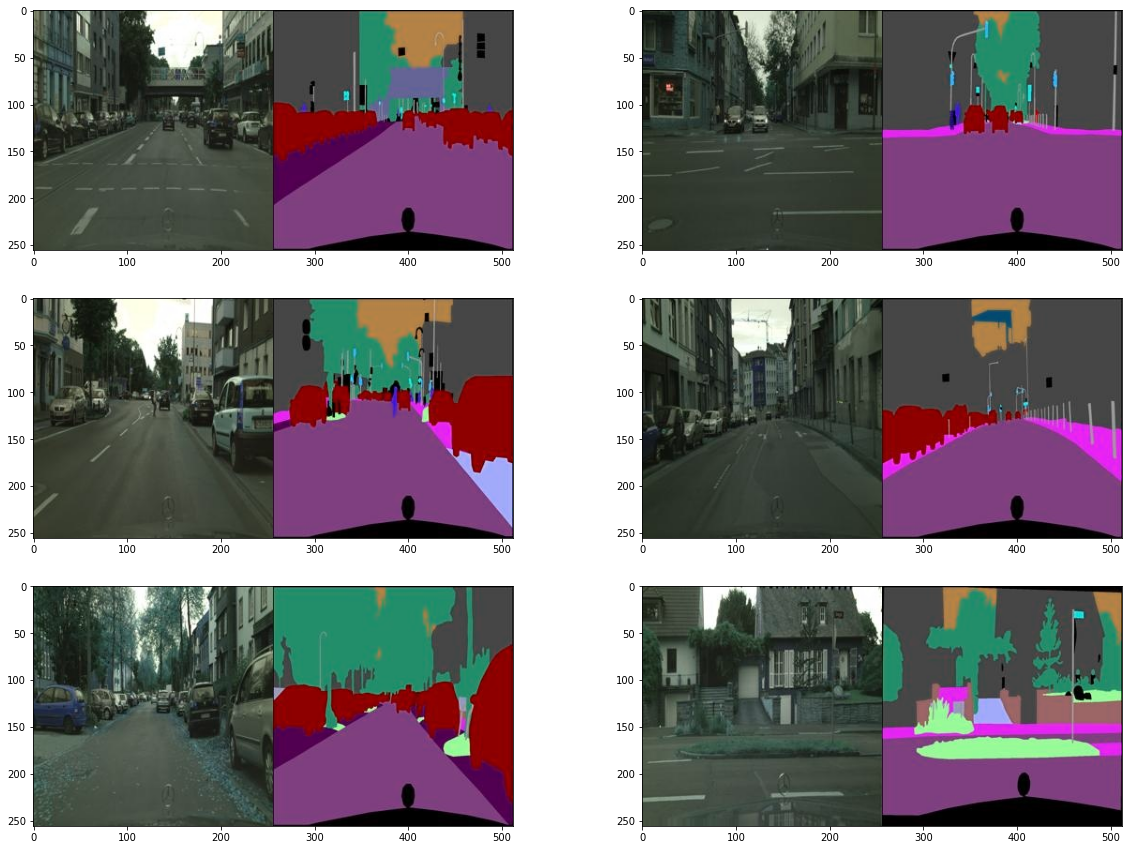

In [3]:
#data 확인
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
#data shape 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 512, 3)


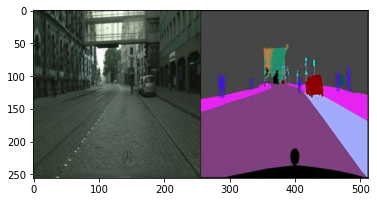

In [5]:
#data shape 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
plt.imshow(img) # 왼쪽이 만들어야할 target 오른쪽이 input
print(img.shape)

####  1.1. Normalization

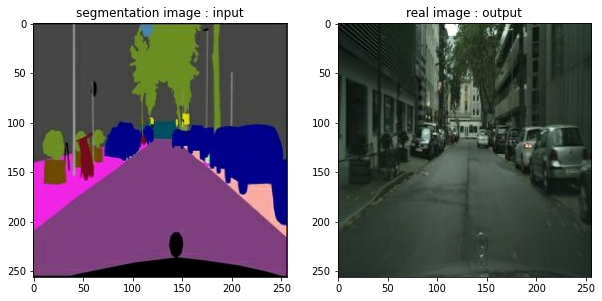

In [6]:
def normalize(x):# -1~1 사이로 정규화
    return (x/127.5) - 1

# 왜 -1~1 값을 사용하는 가?
# 정규화된 픽셀 값을 사용함으로써 모델의 안정성이 향상
# 데이터 분포의 평균을 0으로 맞추고 단위 분산을 갖도록 조정하여 모델의 학습 효율을 향상

def denormalize(x): # 원래 픽셀 정보 복원
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)

    w = tf.shape(img)[1] // 2 # 세트로 된 이미지 분리
    real_image = img[:, :w, :] # output
    real_image = tf.cast(real_image, tf.float32)
    
    seg_image = img[:, w:, :] # input
    seg_image = tf.cast(seg_image, tf.float32)
    return normalize(seg_image), normalize(real_image)

f = data_path + os.listdir(data_path)[1]
seg, real = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg)); plt.title('segmentation image : input')
plt.subplot(1,2,2); plt.imshow(denormalize(real)); plt.title('real image : output')
plt.show()

####  1.2. Augmentation
- 사용기법  
(1) padding  
(2) crop  
(3) flip (up-down, right-left)  
(4) rotation

In [7]:
@tf.function() # 텐서플로 연산을 빠르게 수행하기 위해 tf.function()을 사용합니다.
def apply_augmentation(seg, real):
    stacked = tf.concat([seg, real], axis=-1) # seg와 real을 쌓아 하나의 텐서로 결합합니다.

    _pad = tf.constant([[30,30],[30,30],[0,0]]) 
    # 패딩을 정의합니다. [위쪽, 아래쪽], [왼쪽, 오른쪽], [앞, 뒤]
    # 얼마나 값을 추가할 지를 지정
    
    if tf.random.uniform(()) < .5: # 임의의 스칼라를 호출
        padded = tf.pad(stacked, _pad, "REFLECT") 
        # 패딩 방법으로 "REFLECT"를 사용하여 stacked을 패딩합니다.
        # 일정 경계를 기반으로 반사하여 값을 채움
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) 
        # 패딩 방법으로 "CONSTANT"를 사용하여 stacked을 패딩하고 상수값 1을 사용합니다.
        # 크기를 1로 채움

    out = image.random_crop(padded, size=[256, 256, 6]) 
    # 패딩된 텐서를 무작위 크롭하여 크기를 [256, 256, 6]으로 만듭니다.

    out = image.random_flip_left_right(out) 
    # 무작위로 좌우 반전을 수행합니다.
    out = image.random_flip_up_down(out) 
    # 무작위로 상하 반전을 수행합니다.

    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32) 
        # 1에서 4 사이의 임의의 정수를 호출하여 회전 각도를 정합니다.
        out = image.rot90(out, k=degree) 
        # out을 degree만큼 회전시킵니다.

    return out[...,:3], out[...,3:] 
    # out에서 첫 번째 세 개의 채널과 마지막 세 개의 채널을 분리하여 반환합니다.
    # (256, 512, 3) + (256, 512, 3) 의 axis= -1의 z 방향 결합으로
    # seg , real을 다시 분리하여 return함

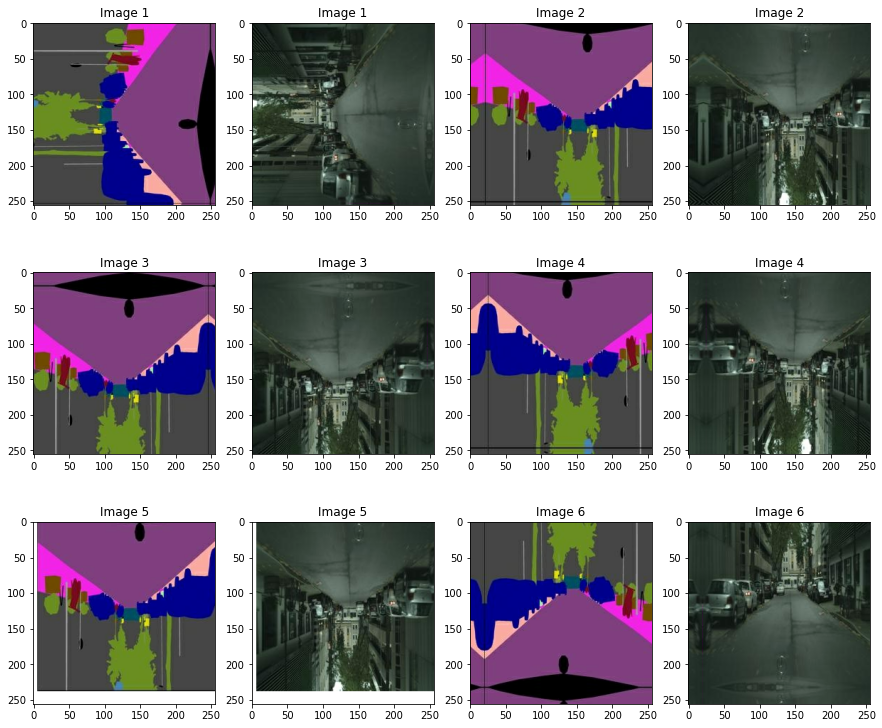

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg, augmented_real = apply_augmentation(seg, real)

    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1);
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

#### 1.3 Dataset 구성

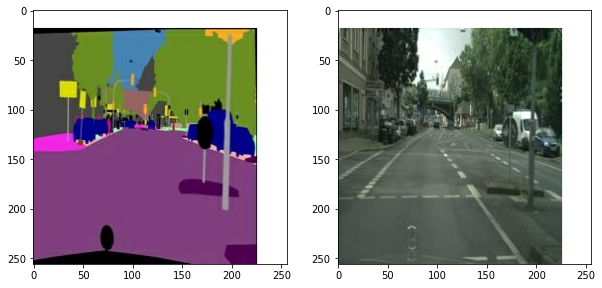

In [9]:
def get_train(img_path):
    seg, real = load_img(img_path) # 한 개의 이미지에서 seg(세그멘테이션 결과)와 real(원본 이미지)로 분리
    seg, real = apply_augmentation(seg, real) # 데이터 증강을 적용
    return seg, real

# 파일 경로 패턴에 맞는 이미지 파일들의 경로를 데이터셋으로 생성합니다.
train_images = data.Dataset.list_files(data_path + "*.jpg")

# get_train 함수를 거친 뒤, 데이터를 섞고 배치로 구성
# Batch 크기 4
train_images = train_images.map(get_train).shuffle(100).batch(4)

# train_images에서 하나의 배치(sample)를 가져옵니다.
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator()) # 텐서를 넘파이 배열로 변환합니다.

# 이를 원래 pixel로 되돌리기 위해 1을 더하고 127.5를 곱함 (0 ~ 255 범위의 값)
seg, real = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

# 시각화를 위해 두 개의 이미지를 나란히 출력합니다.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(seg[0].astype(np.uint8)) # seg 이미지 출력
plt.subplot(1, 2, 2); plt.imshow(real[0].astype(np.uint8)) # real 이미지 출력


### 2. Build Model Architecture

#### model structure of Unet
![pix2pix](https://d3s0tskafalll9.cloudfront.net/media/images/refer_g.max-800x600.png)

#### 2.1.Build Generator : Unet

In [10]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [13]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [16]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]

        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))

        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))

        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)

    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)

        features = features[:-1]

        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])

        x = self.last_conv(x)
        return x

    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [17]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

#### 2.2(extra)Bulid generator using functional API

```Python
encode_filters = [64,128,256,512,512,512,512,512]
decode_filters = [512,512,512,512,256,128,64]

def encoded(x, n_filter, use_bias = True, bn = True, dropout=True, act = 'leak'):
    if use_bias :
        x = layers.Conv2D(n_filter, 4, 2, "same", use_bias=True)(x)
    else: 
        x = layers.Conv2D(n_filter, 4, 2, "same", use_bias=False)(x)
        
    if dropout :
        x = layers.Dropout(0.5)(x)    
    if bn :
        self.batchnorm = layers.BatchNormalization()(x)
    
    if 'leak':
        x = layers.ReLU(0.2)(x)
    else :
        x = layes.Sigmoid()(x)
    
    return x
        
        
def decoded(x, n_filter, use_bias = True, dropout=True):
    
    if dropout :
        x = layers.Dropout(0.5)(x)    
    x = layers.Conv2DTranspose(n_filter, 4, 2, "same", use_bias=False)
    x = layers.BatchNormalization()
    x = layers.ReLU()
    
    return x

def Generator_unet(img):
    
    x = Input(shape = (img.shape[0],))
    
    encode_filters = [64,128,256,512,512,512,512,512]
    decode_filters = [512,512,512,512,256,128,64]
    
    # encoder
    features = []
    for i, n_filter in enumerate(encode_filters):
        if i == 0:
            x = encoded(x, n_filte, bn = False)
        else:
            x = encoded(x, n_filter)
            
        features.append(x)
        
    # decoder
    self.decode_blocks = []
    for i, n_filter, feat in enumerate(zip(decode_filters,features[::-1])):
        if i < 3:
            x = decoded(n_filter)
        else:
            x = decoded(n_filter, dropout=False)
            
        x = layers.Concatenate()([x, feat])

    x = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False, activation= 'tanh')(x)
    
    return tf.keras.Model(inputs=img, outputs=x) # model 자체를 return
```

#### 2.3 Build Discriminator

![image](https://d3s0tskafalll9.cloudfront.net/media/images/refer_d.max-800x600.png)

In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act

        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)

        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None

    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)

        if self.use_bn:
            x = self.batchnorm(x)

        if self.act:
            x = self.lrelu(x)
        return x

In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        
        # 조건이 너무 많음 
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, use_bn=False)
        self.block3 = DiscBlock(n_filters=128, stride=2)
        self.block4 = DiscBlock(n_filters=256, stride=2)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, x, y):
        x = self.block1([x, y])
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        return self.sigmoid(x)

    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

In [21]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

#### 2.4.(extra)Build discriminator using functional API 
```python
def discblock(x, n_filter, stride=2, custom_pad=False, use_bn=True, act=True):
    if custom_pad:
        x = layers.ZeroPadding2D()(x)
        x = layers.Conv2D(n_filter, 4, stride, "valid", use_bias=False)(x)
    else:
        x = layers.Conv2D(n_filter, 4, stride, "same", use_bias=False)(x)
        
    if use_bn:
        x = layers.BatchNormalization()(x)
        
    if act:
        x = layers.LeakyReLU(0.2)(x)
    else:
        x = layers.sigmoid()(x)
        
def discriminator(fake, real):
    
    x = layers.Concatenate([fake, real])
    filters = [64,128,256,512,1]
    
    for i, n_filter in enumerate(filters):
        if i == 0:
            x = discblock(x, n_filter, bn = False)
        elif i >= 3:
            x = discblock(x, n_filter, stride = 1, bn = False, custom_pad = True)
        elif i == 4:
            x = discblock(x, n_filter, stride = 1, bn = False, custom_pad = True, act = False)
        
            
    return Model(inputs = input, outputs = x)
```

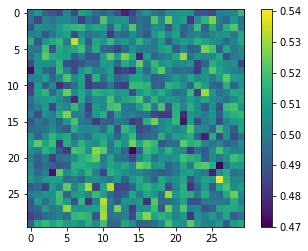

In [22]:
# discriminator test
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

이전 PatchGAN에 대해 설명했던 것처럼, 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀 값은 원래 입력의 (70,70) 패치에 대한 분류 결과입니다. 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있겠죠. 각각의 픽셀 값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는 데 사용합니다.`(이진분류)`

### 3. Train Model

#### 3.1 Crossentropy

모델 두 개를 동시에 학습시키기 위하여 별개의 Crossentropy 구축

In [23]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc) # 이진분류 손실함수

#### 3.2 Optimizer

모델 두 개를 별개의 gradient로 최적화 시키기 위해 별개의 optimizer 사용

In [24]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
#beta_1: 그라디언트의 일차 모멘트(gradient's first moment)에 대한 지수 감소율
#beta_2: 그라디언트의 이차 모멘트(gradient's second moment)에 대한 지수 감소율

#### 3.3 Train function

In [25]:
@tf.function
def train_step(seg, real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        
        # Generator 예측
        fake = generator(seg, training=True)
        # Discriminator 예측
        fake_disc = discriminator(seg, fake, training=True)
        real_disc = discriminator(seg, real, training=True)
        # Generator 손실 계산 (fake-real 판단 정도의 차이를 loss로 환산함)
        gene_loss, l1_loss = get_gene_loss(fake, real, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc) 

    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

#### 3.4 Training

In [26]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (seg, real) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg, real)

        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8691                     
L1_loss:0.3021                     
Discriminator_loss:1.4591

EPOCH[1] - STEP[20]                     
Generator_loss:0.8024                     
L1_loss:0.2527                     
Discriminator_loss:1.3693

EPOCH[1] - STEP[30]                     
Generator_loss:0.7632                     
L1_loss:0.2096                     
Discriminator_loss:1.3322

EPOCH[1] - STEP[40]                     
Generator_loss:0.9750                     
L1_loss:0.1921                     
Discriminator_loss:1.2238

EPOCH[1] - STEP[50]                     
Generator_loss:0.9226                     
L1_loss:0.1862                     
Discriminator_loss:1.1301

EPOCH[1] - STEP[60]                     
Generator_loss:0.6841                     
L1_loss:0.1733                     
Discriminator_loss:1.2325

EPOCH[1] - STEP[70]                     
Generator_loss:1.1712                     
L1_loss:0.2161                    

### 5. Results

#### 5.1.Results of Model Training for 10 Epochs

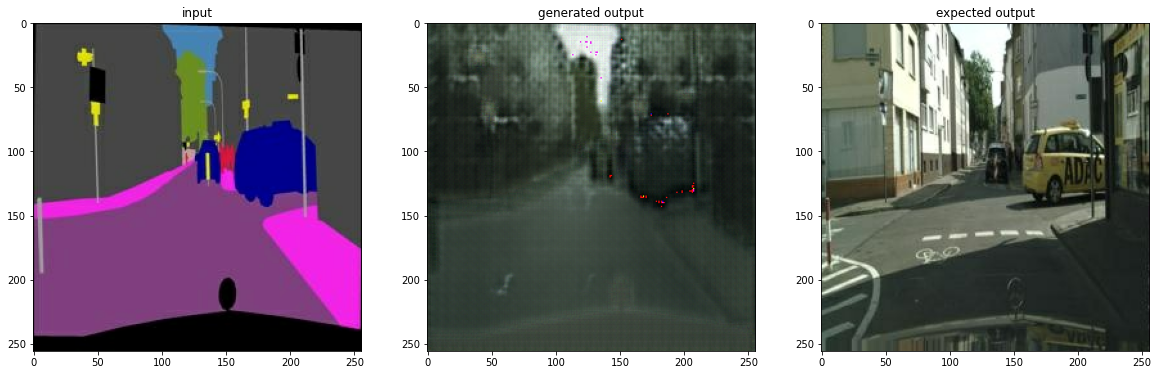

In [28]:
test_ind = 1
val_path = './cityscapes/val/'

try:
    f = val_path + os.listdir(val_path)[test_ind]
except:
    idx = np.random.randint(len(os.listdir(val_path)))
    print(f"{test_ind} was out of bounds, we called {idx}.")
    f = val_path + os.listdir(val_path)[idx]
    
seg, real = load_img(f)

pred = generator(tf.expand_dims(seg, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg)) ; plt.title('input')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('generated output')
plt.subplot(1,3,3); plt.imshow(denormalize(real)); plt.title('expected output')
plt.show()

#### 5.2.Model Improvement : Additional Training

In [ ]:
EPOCHS += 80
# 100 epochs 채워봄 

for epoch in range(1, EPOCHS+1):
    for i, (seg, real) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg, real)

        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:0.5093                     
L1_loss:0.1380                     
Discriminator_loss:1.6554

EPOCH[1] - STEP[200]                     
Generator_loss:2.1521                     
L1_loss:0.1632                     
Discriminator_loss:0.4903

EPOCH[2] - STEP[100]                     
Generator_loss:2.2185                     
L1_loss:0.1972                     
Discriminator_loss:0.5163

EPOCH[2] - STEP[200]                     
Generator_loss:1.4275                     
L1_loss:0.1667                     
Discriminator_loss:0.5561

EPOCH[3] - STEP[100]                     
Generator_loss:2.1617                     
L1_loss:0.2042                     
Discriminator_loss:0.8984

EPOCH[3] - STEP[200]                     
Generator_loss:0.6702                     
L1_loss:0.1641                     
Discriminator_loss:0.9895

EPOCH[4] - STEP[100]                     
Generator_loss:0.9461                     
L1_loss:0.1761             

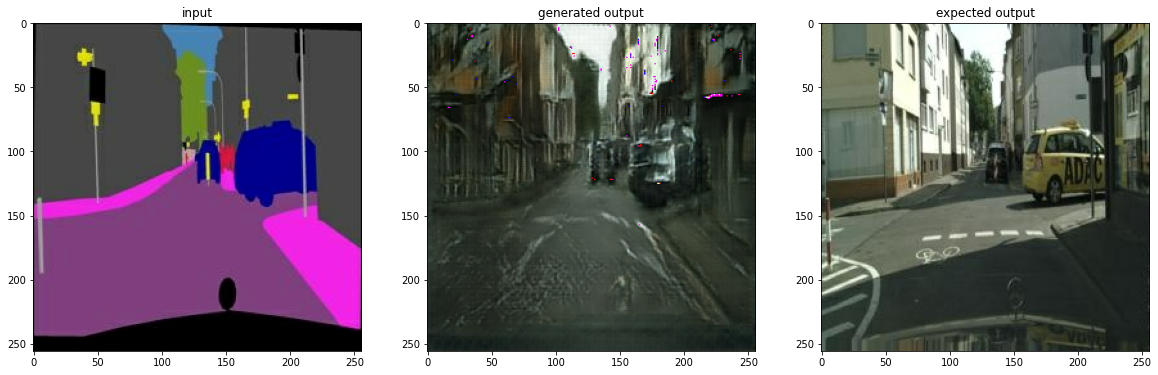

In [31]:
try:
    f = val_path + os.listdir(val_path)[test_ind] # test_ind = 1 10 epoch 모델과 동일 그림 확인
except:
    idx = np.random.randint(len(os.listdir(val_path)))
    print(f"{test_ind} was out of bounds, we called {idx}.")
    f = val_path + os.listdir(val_path)[idx]
    
seg, real = load_img(f)

pred = generator(tf.expand_dims(seg, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg)) ; plt.title('input')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('generated output')
plt.subplot(1,3,3); plt.imshow(denormalize(real)); plt.title('expected output')
plt.show()

In [40]:
# !mv training_checkpoints epoch_100_ckpt
# !mkdir training_checkpoints

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [43]:
EPOCHS = 200
# 300 epochs 채워봄 

for epoch in range(1, EPOCHS+1):
    for i, (seg, real) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg, real)

        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:0.9889                     
L1_loss:0.1533                     
Discriminator_loss:2.6678

EPOCH[1] - STEP[200]                     
Generator_loss:1.7998                     
L1_loss:0.1900                     
Discriminator_loss:0.4213

EPOCH[2] - STEP[100]                     
Generator_loss:0.5233                     
L1_loss:0.2004                     
Discriminator_loss:1.4845

EPOCH[2] - STEP[200]                     
Generator_loss:0.9293                     
L1_loss:0.1433                     
Discriminator_loss:1.8887

EPOCH[3] - STEP[100]                     
Generator_loss:0.6836                     
L1_loss:0.1449                     
Discriminator_loss:1.7051

EPOCH[3] - STEP[200]                     
Generator_loss:2.3878                     
L1_loss:0.1751                     
Discriminator_loss:0.5676

EPOCH[4] - STEP[100]                     
Generator_loss:1.4489                     
L1_loss:0.1729             

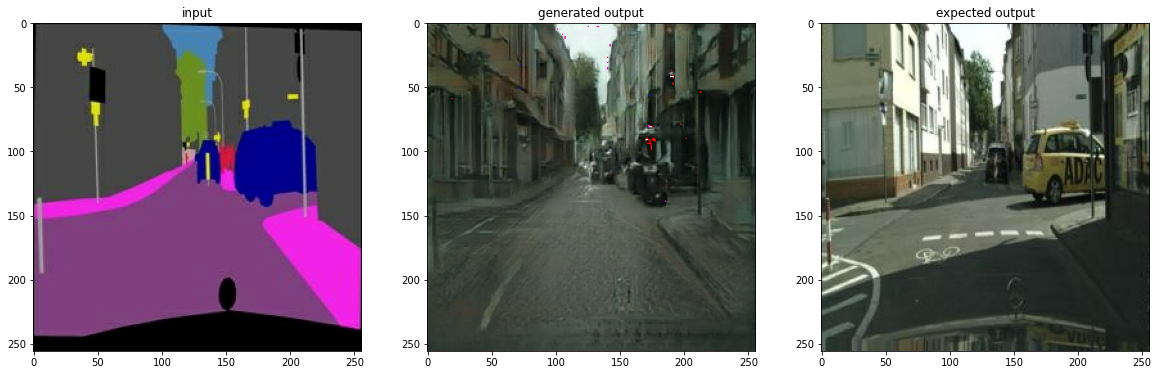

In [44]:
try:
    f = val_path + os.listdir(val_path)[test_ind] # test_ind = 1 10 epoch 모델과 동일 그림 확인
except:
    idx = np.random.randint(len(os.listdir(val_path)))
    print(f"{test_ind} was out of bounds, we called {idx}.")
    f = val_path + os.listdir(val_path)[idx]
    
seg, real = load_img(f)

pred = generator(tf.expand_dims(seg, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg)) ; plt.title('input')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('generated output')
plt.subplot(1,3,3); plt.imshow(denormalize(real)); plt.title('expected output')
plt.show()

In [45]:
for epoch in range(1, EPOCHS+1):
    for i, (seg, real) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg, real)

        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        if i == 0:
            checkpoint.save(file_prefix=checkpoint_prefix) # 300 epoch 모델 저장하고 끔
            break
    break

In [46]:
!mv training_checkpoints epoch_300_ckpt

#### 5.4.(extra)load model
##### 5.4.1.Restoring the latest checkpoint in checkpoint_dir

In [58]:
checkpoint.restore(tf.train.latest_checkpoint('epoch_100_ckpt'))

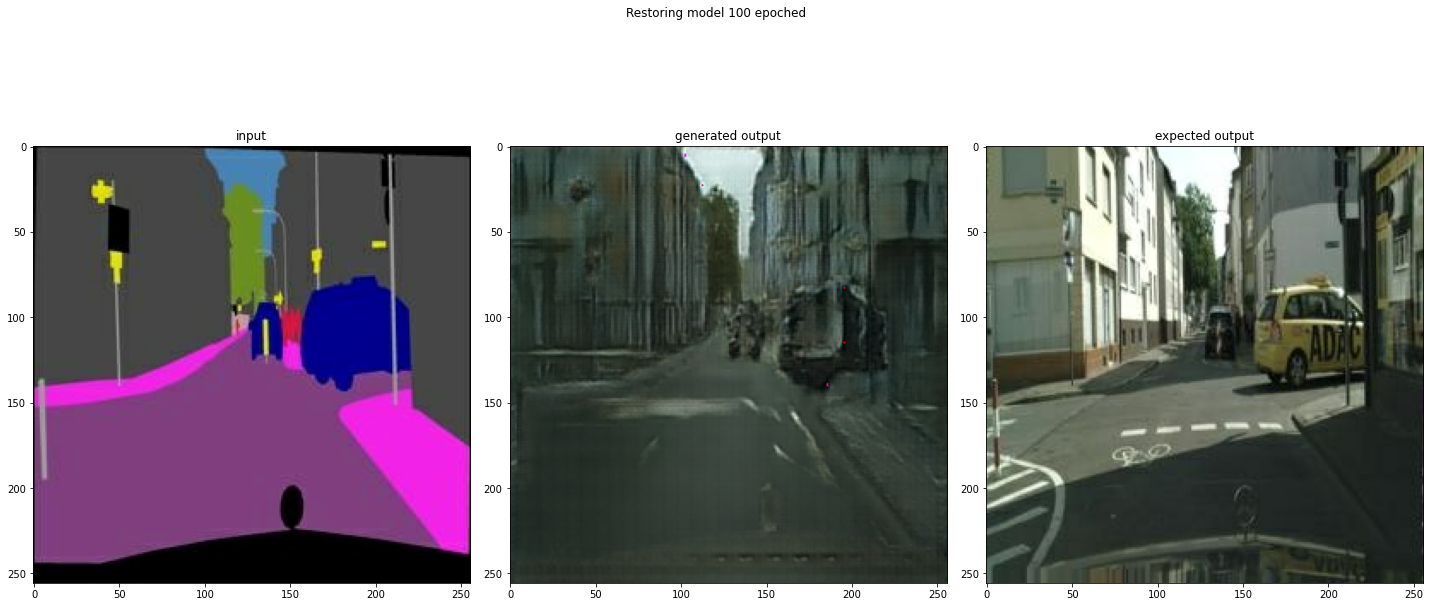

In [62]:
try:
    f = val_path + os.listdir(val_path)[test_ind] # test_ind = 1 10 epoch 모델과 동일 그림 확인
except:
    idx = np.random.randint(len(os.listdir(val_path)))
    print(f"{test_ind} was out of bounds, we called {idx}.")
    f = val_path + os.listdir(val_path)[idx]
    
seg, real = load_img(f)

pred = generator(tf.expand_dims(seg, 0))
pred = denormalize(pred)

##### 5.4.2.Ploting result of loaded model

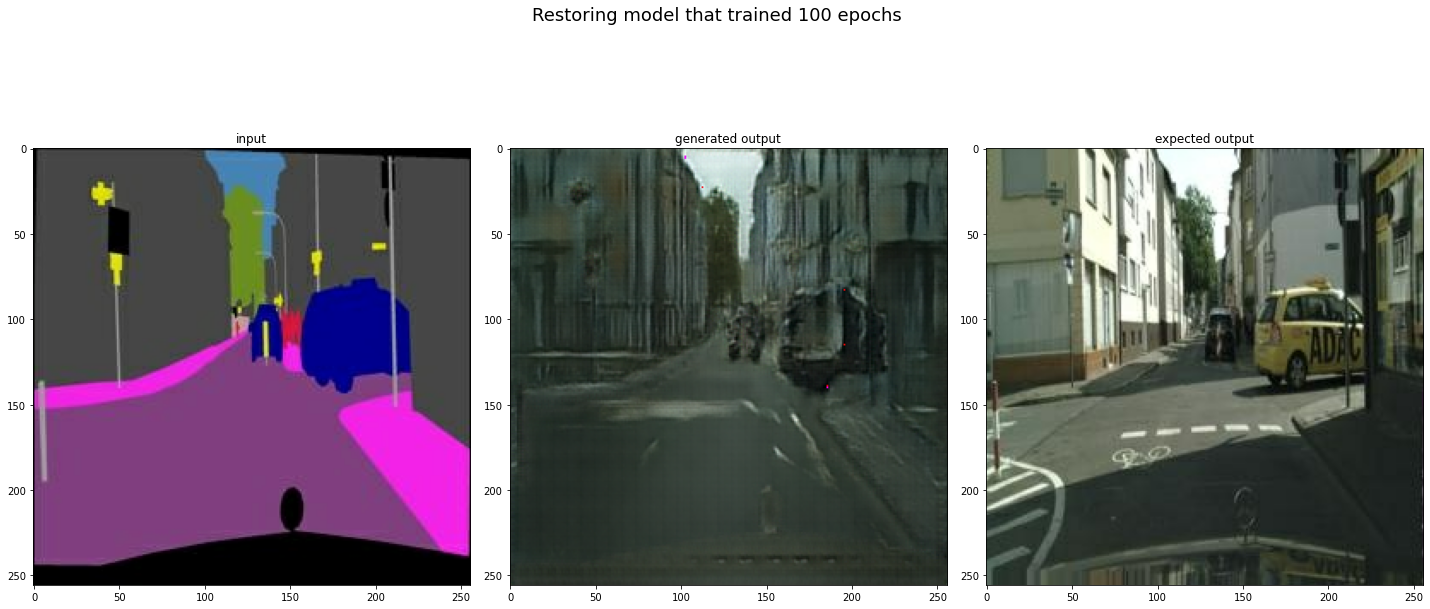

In [72]:
#checkpoint 테스트하다가 110~120 epoch 쯤 갔을때 저장해서 그림이 위의 예시보단 좀 더 세밀해졌음
plt.figure(figsize=(20,10))
plt.suptitle('Restoring model that trained 100 epochs', fontsize = 18) # 간격 무슨일..
plt.subplot(1,3,1);
plt.imshow(denormalize(seg)) ;
plt.title('input')
plt.subplot(1,3,2); 
plt.imshow(pred[0]); 
plt.title('generated output')
plt.subplot(1,3,3); 
plt.imshow(denormalize(real));
plt.title('expected output')
plt.tight_layout()

plt.show()

In [75]:
# !tar zcvf e100ckpt.tar.gz epoch_100_ckpt
# !tar zcvf e300ckpt.tar.gz epoch_300_ckpt

epoch_100_ckpt/
epoch_100_ckpt/.ipynb_checkpoints/
epoch_100_ckpt/ckpt-3.data-00000-of-00001
epoch_100_ckpt/checkpoint
epoch_100_ckpt/ckpt-3.index
epoch_300_ckpt/
epoch_300_ckpt/ckpt-4.index
epoch_300_ckpt/ckpt-4.data-00000-of-00001
epoch_300_ckpt/checkpoint


## Discussion

- 생각보다 10 epochs만으로도 성능이 예상한 것보다 괜찮게 나옴
- 확실히 많이 학습할 수록 expected output(real image)와 비슷한 경향의 그림이 나옴


- GAN의 input이 random noise라는 것이 이번에 알게된 사실
- Unet이 image를 input으로 넣는 것을 알고 있었기 떄문에 GAN에 대해 이해하는 데 더 도움이 된 것 같음
- 자꾸 변수를 같은데 저장해서 10, 100, 300 비교사진을 코드로 같이 붙혀넣지를 못함


- 함수형으로 변형해서 일부 구현해봤는데 구현 측면에서는 functional이 좀 더 쉬운 느낌 (익숙해서 그런 걸 수 도 있음)
- 함수형은 subclass 포맷에서 사용하는  training=False 인자를 사용하지 못하는 줄 알았는데  
return을 Model로 받아서 사용이 가능한 것으로 보임